In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import QuantileRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

quantile_estimator_params = {
        "GradientBoostingRegressor": {
            "loss_name": "loss",
            "alpha_name": "alpha"
        },
        "QuantileRegressor": {
            "loss_name": "quantile",
            "alpha_name": "quantile"
        },
        "HistGradientBoostingRegressor": {
            "loss_name": "loss",
            "alpha_name": "alpha"
        },
        "LGBMRegressor": {
            "loss_name": "objective",
            "alpha_name": "alpha"
        },
}

def get_cmap(n, name='Set1'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

# Function needed to run the notebooks

In [2]:
def get_estimator(name, poly_d=10):
    """
    Function to return an estimator.
    """
    random_state = 1
    if name == "GradientBoostingRegressor":
        return GradientBoostingRegressor(loss="quantile", random_state=random_state)
    if name == "QuantileRegressor":
        return QuantileRegressor(solver="highs", alpha=0)
    if name == "polynomial":
        degree_polyn = poly_d
        polyn_model_quant = Pipeline(
            [
                ("poly", PolynomialFeatures(degree=degree_polyn)),
                ("linear", QuantileRegressor(
                        solver="highs",
                        alpha=0,
                ))
            ]
        )
        return polyn_model_quant

def quantile_regression(checked_estimator, X_train, y_train, X_test, y_test, alpha):
    """
    Returns the output of quantile regression.
    """
    if isinstance(checked_estimator, Pipeline):
        estimator = checked_estimator[-1]
    else:
        estimator = checked_estimator
    name_estimator = estimator.__class__.__name__
    alpha_name = quantile_estimator_params[name_estimator]["alpha_name"]
    alphas = [alpha/2, (1 - alpha/2)]
    y_preds = []
    if isinstance(checked_estimator, Pipeline):
        for a in alphas:
            estimator_ = clone(checked_estimator)
            params = {alpha_name: a}
            estimator_[-1].set_params(**params)
            estimator_.fit(X_train, y_train)
            y_preds.append(estimator_.predict(X_test))
    else:
        for a in alphas:
            estimator_ = clone(estimator)
            params = {alpha_name: a}
            estimator_.set_params(**params)
            estimator_.fit(X_train, y_train)
            y_preds.append(estimator_.predict(X_test))
    return y_preds




# Simulated data

To show our results of the analysis we will use the simulated data from the paper by Romano et al. (2020). Note that you can simulate other datasets using the `get_data()` function defined below.

In [3]:
def x_sinx(x, random_state):
    rng = np.random.default_rng(random_state)
    ax = 0*x
    for i in range(len(x)):
        ax[i] = rng.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*rng.random()
        ax[i] += 25*(rng.uniform(0, 1, 1) < 0.01)*rng.random()
    return ax.astype(np.float32)

def get_data(funct, n_samples, random_state, random_data=True, random_split=True, noise=0.5, mu=None, sigma=None, min_x=0, max_x=10, data_name=None, test_size=0.3):
    """
    Returns simulated data.
    """
    if random_split:
        random_state_split = random_state
    else: 
        random_state_split = 1
    
    if random_data:
        rng = np.random.default_rng(random_state)
    else: 
        rng = np.random.default_rng(1)
        random_state = 1

    if mu is not None and sigma is not None:
        X_train = rng.normal(mu, sigma, n_samples)
        X_test = np.arange(mu-4*sigma, mu+4*sigma, sigma/20.)
    else:
        X_train = rng.uniform(min_x, max_x, size=n_samples).astype(np.float32)
        X_test = rng.uniform(min_x, max_x, size=n_samples).astype(np.float32)

    y_train, y_test, y_mesh = funct(X_train, random_state=random_state), funct(X_test, random_state=random_state), funct(X_test, random_state=random_state)

    if data_name!="paper_reproduction":
        y_train += rng.normal(0, noise, y_train.shape[0])
        y_test += rng.normal(0, noise, y_test.shape[0])

    if mu is None and sigma is None:
        X_train = np.reshape(X_train, (n_samples, 1))
        X_test = np.reshape(X_test, (n_samples, 1))
    
    X_train_, X_calib_, y_train_, y_calib_ = train_test_split(
        X_train,
        y_train,
        test_size=test_size,
        random_state=random_state_split
    )
    return X_train_, X_calib_, y_train_, y_calib_, X_test, y_test, y_mesh


In [8]:
def CQR_alphas(alphas, random_data, random_split, iters=0, n_samples=1000, funct=x_sinx, name_estimator="GradientBoostingRegressor", symmetry=True):
    """
    Checking what happens when you vary alpha for different types of splits of the dataset.
    """
    mapie_coverage = []
    interval_width = []
    list_scores = []

    if iters>0:
        for i in range(iters):
            mc, iw, ls = CQR_alphas(alphas, random_data=random_data, random_split=random_split, n_samples=n_samples, funct=funct, name_estimator=name_estimator, symmetry=symmetry)
            mapie_coverage.append(mc)
            interval_width.append(iw)
            list_scores.append(ls)
    else:
        mapie_coverage_ = []
        interval_width_ = []
        list_scores_ = []
        random_state = np.random.randint(0, 1000)
        X_train_, X_calib_, y_train_, y_calib_, X_test, y_test, _ = get_data(funct, n_samples=n_samples, random_state=random_state, random_data=random_data, random_split=random_split, data_name="paper_reproduction")
        for alpha in alphas:
            estimator = get_estimator(name_estimator)
            mapie_reg = MapieQuantileRegressor(
                estimator=estimator,
                alpha=alpha,
            )
            mapie_reg.fit(X_train_, y_train_, X_calib=X_calib_, y_calib=y_calib_)
            y_pred, y_pis, = mapie_reg.predict(X_test, symmetry=symmetry)

            mapie_coverage_.append(regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0]))
            list_scores_.append(mapie_reg.conformity_scores_)
            interval_width_.append(regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0]))
        return mapie_coverage_, interval_width_, list_scores_
    return mapie_coverage, interval_width, list_scores


def plot_coverages_widths(alpha, coverage, width, method, ylim=None):
    """
    Plotting the coverage and width against target coverage.
    """
    try :
        coverage[0][0]
        method = ["split "+str(i+1) for i in range(len(coverage))]
        title = "Effect of random split"
    except:
        coverage = [coverage]
        width = [width]
        method = [method]
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(len(coverage)):
        axs[0].plot(1 - np.array(alpha), coverage[i], label=method[i])
        axs[1].plot(1 - np.array(alpha), width[i], label=method[i])
        axs[0].scatter(1 - np.array(alpha), coverage[i], s=10, alpha=0.6)
        axs[1].scatter(1 - np.array(alpha), width[i], s=10, alpha=0.6)
    axs[0].set_xlabel("Target coverage")
    axs[0].set_ylabel("Coverage score")
    axs[0].plot([np.min(1 - alphas), np.max(1 - alphas)], [np.min(1 - alphas), np.max(1 - alphas)], label="x=y", color="black")
    axs[0].legend()
    axs[0].set_title("Actual vs target coverage")
    axs[1].set_xlabel("Target coverage")
    axs[1].set_ylabel("Average size of prediction sets")
    if ylim is not None:
        axs[1].set_ylim(ylim)
    axs[1].legend()
    axs[1].set_title("Prediction interval vs target coverage")
    plt.show()


def plot_coverage_quantile(alpha, scores, ylim=None):
    """
    Plotting the coverage and width against target coverage.
    """
    quantiles = []
    for i, item in enumerate(scores):
        q = (1 - (alpha[i])) * (1 + (1 / len(item)))
        quantiles.append(np.quantile(item, q))

    fig, axs = plt.subplots(figsize=(12, 5))
    axs.plot(1 - np.array(alpha), quantiles)
    axs.scatter(1 - np.array(alpha), quantiles, s=10, alpha=0.6)
    axs.set_xlabel("Target coverage")
    axs.set_ylabel("quantile value")
    if ylim is not None:
        axs.set_ylim(ylim)
    plt.show()

def plot_scores(alphas, scores, bins="auto", xlim=None):
    """
    Plotting the different values of alphas on the histogram 
    of the scores. This is the same function that defines the
    the added value by the conformal method.
    """
    fig, axs = plt.subplots(1, len(scores), figsize=(20, 4))
    for i in range(len(scores)):
        score_ = scores[i][0][2]
        q = (1 - (alphas[0])) * (1 + (1 / len(score_)))
        quantile = np.quantile(score_, q)
        axs[i].set_xlabel("Conformity scores")
        axs[i].hist(score_, bins=bins)
        axs[i].axvline(quantile, ls="--", color="k")
        axs[i].set_title(f"split={i}\nquantile={quantile}")
        if xlim is not None:
            axs[i].set_xlim(xlim)
    plt.show()


We will make five different splits of the dataset and check what happens in each of the splits, how they differ in target vs. realised coverage. 

In [6]:
alphas = np.arange(0.01, 0.99, 0.5)
mapie_coverage, mapie_width, _ = CQR_alphas(alphas=alphas, random_data=False, random_split=True, iters=5)

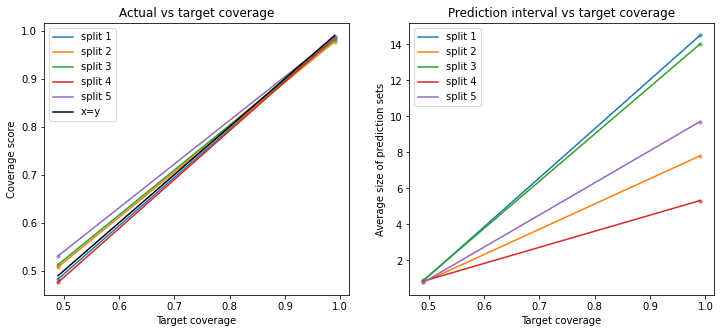

In [10]:
plot_coverages_widths(alphas, mapie_coverage, mapie_width, method="CQR")

We can see that the actual coverage sometimes varies quite a bit  target coverage, the goal would be that they are nearly identical for any alpha. Note that we see that as alpha gets smaller on the graph on the right hand side, the prediction interval seems to shoot up for the last values. 

We will now observe the difference between the target coverage and the actual coverage averaged over all the splits.

In [11]:
alphas = np.arange(0.01, 0.99, 0.05)
mapie_coverage, interval_width, _ = CQR_alphas(alphas, random_data=False, random_split=True, iters=5)
avg_mapie_coverage, avg_interval_width = np.mean(mapie_coverage, axis=0), np.mean(interval_width, axis=0)

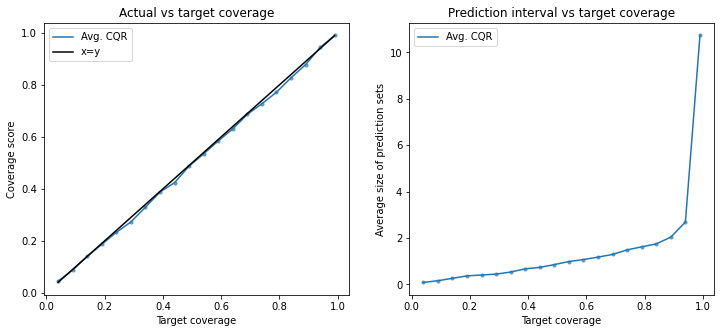

In [12]:
plot_coverages_widths(alphas, avg_mapie_coverage, avg_interval_width, method="Avg. CQR")

We can see that the target coverage and actual coverage are very close, this is important because it's a key aspect and we see that averaging over the split gives a better performance. This shows that the implementation of a cross-cv would be of benefit.

In [16]:
alphas = np.arange(0.01, 0.99, 0.2)
mapie_coverage, interval_width, list_scores = CQR_alphas(alphas, random_data=False, random_split=True, iters=5)
mean_scores = np.mean(list_scores, axis=0)
scores = []
for item in mean_scores:
    scores.append(item[2])


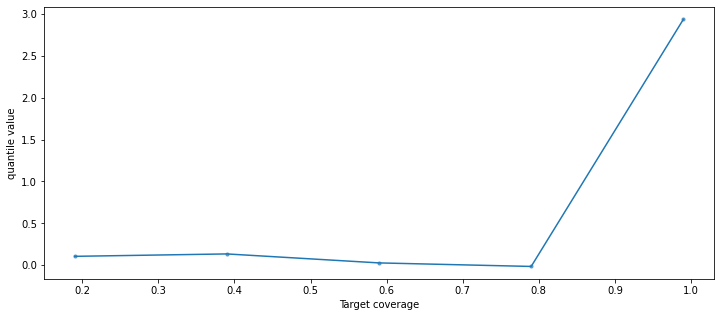

In [17]:
plot_coverage_quantile(alphas, scores)

In [15]:
alphas = np.arange(0.01, 0.99, 0.2)
results_ = testing_para_CQR(iters=5, alphas=alphas)

NameError: name 'testing_para_CQR' is not defined

In [ ]:
plt.plot(target_coverage, initial_width)

Now we will check how the quantile value changes depending on the split for the same alpha.

In [ ]:
alphas = [0.2]
mapie_coverage, interval_width, list_scores = CQR_alphas(alphas, random_data=False, random_split=True, iters=5)


In [ ]:
plot_scores(alphas, list_scores, xlim=(-1.5, 0.5))

In [ ]:
def testing_para_CQR(iters, n_samples=1000, alphas=0.1, funct=x_sinx, estimator_name="GradientBoostingRegressor", symmetry=True):
    """
    Testing how changing the number of samples or the value of alpha affects both coverage and interval width.
    """
    random_state = 1
    if isinstance(n_samples, list) and isinstance(alphas, list):
        raise ValueError("Either n_samples or alphas needs to be a single value.")
    if isinstance(n_samples, int) and isinstance(alphas, float):
        raise ValueError("Either n_samples or alphas needs to be a list.")
    
    list_values = []
    list_initial_coverage = []
    list_mapie_coverage = []
    list_initial_width = []
    list_mapie_width = []
    list_scores = []

    if isinstance(alphas, float):
        name = "n_samples"
        values = n_samples
    else:
        name = "alphas"
        values = alphas

    for value in values:
        for i in range(iters):
            random_state = np.random.randint(0, 1000)
            list_values.append(value)
            if isinstance(alphas, float):
                    X_train_, X_calib_, y_train_, y_calib_, X_test, y_test, _ = get_data(funct, n_samples=value, random_state=random_state, data_name="paper_reproduction")
            else:
                    X_train_, X_calib_, y_train_, y_calib_, X_test, y_test, _ = get_data(funct, n_samples=n_samples, random_state=random_state, data_name="paper_reproduction")
            try:
                estimator=get_estimator(estimator_name)
                if isinstance(n_samples, int):
                    mapie_reg = MapieQuantileRegressor(
                            estimator=estimator,
                            alpha=value,
                    )
                    y_pred_qr = quantile_regression(estimator, X_train_, y_train_, X_test, y_test, alpha=value)
                else:
                    mapie_reg = MapieQuantileRegressor(
                            estimator=estimator,
                            alpha=alphas,
                    )
                    y_pred_qr = quantile_regression(estimator, X_train_, y_train_, X_test, y_test, alpha=alphas)

                mapie_reg.fit(X_train_, y_train_, X_calib=X_calib_, y_calib=y_calib_)
                y_pred, y_pis, = mapie_reg.predict(X_test, symmetry=symmetry)

                list_initial_coverage.append(regression_coverage_score(y_test, y_pred_qr[0], y_pred_qr[1]))
                list_mapie_coverage.append(regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0]))
                list_initial_width.append(regression_mean_width_score(y_pred_qr[0], y_pred_qr[1]))
                list_mapie_width.append(regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0]))

                list_scores.append(mapie_reg.conformity_scores_)
            except:
                list_initial_coverage.append(np.nan)
                list_mapie_coverage.append(np.nan)
                list_initial_width.append(np.nan)
                list_mapie_width.append(np.nan)

    return pd.DataFrame(zip(list_values, list_initial_coverage, list_mapie_coverage, list_initial_width, list_mapie_width), columns=[name, "init_cov", "mapie_cov", "init_piw", "mapie_piw"])

def rename_columns(df):
    df.reset_index(inplace=True)
    name_columns = []
    for item in df.columns:
        name_columns.append("_".join(item))
    df.columns = name_columns
    return df


def plot_value_vs_cov(df):
    fig, axs = plt.subplots(figsize=(10, 6))
    axs2=axs.twinx()
    name = df.columns[0]
    if name == "n_samples_":
        axs.hlines(y=0.9, xmin=np.min(df[name]), xmax=np.max(df[name]), linestyle="--", color="black", label="coverage=0.9")
        extra=25
    else:
        xmin=np.min(df[name])
        xmax=np.max(df[name])
        axs.plot([xmin, xmax], [xmin, xmax], linestyle="--", color="black", label="x=y")
        extra=0.001
    
    axs.plot(df[name], df["init_cov_mean"], color="blue", linestyle="--", label="initial coverage")
    axs.fill_between(df[name], df["init_cov_mean"]-df["init_cov_std"], df["init_cov_mean"]+df["init_cov_std"], color="blue", alpha=0.2)

    axs.plot(df[name], df["mapie_cov_mean"], color="red", linestyle="--", label="mapie coverage")
    axs.fill_between(df[name], df["mapie_cov_mean"]-df["mapie_cov_std"], df["mapie_cov_mean"]+df["mapie_cov_std"], color="red", alpha=0.2)

    axs2.vlines(df[name]-extra, ymin=df["init_piw_mean"]-df["init_piw_std"], ymax=df["init_piw_mean"]+df["init_piw_std"], color="blue", label="initial interval width", alpha=0.8)
    axs2.scatter(df[name]-extra, df["init_piw_mean"], color="blue", alpha=0.8)

    axs2.vlines(df[name]+extra, ymin=df["mapie_piw_mean"]-df["mapie_piw_std"], ymax=df["mapie_piw_mean"]+df["mapie_piw_std"], color="red", label="mapie interval width", alpha=0.8)
    axs2.scatter(df[name]+extra, df["mapie_piw_mean"], color="red", alpha=0.8)

    axs.set_xlabel(name)
    axs.set_ylabel("coverage")
    axs2.set_ylabel("interval width")
    axs.legend(bbox_to_anchor=(0.35, 0.99))
    axs2.legend(bbox_to_anchor=(0.85, 0.99))



Set the values of n_samples and alphas that you will want to test:

In [ ]:
n_samples = [100, 250, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 8000, 10000]
alphas = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.45]


In [ ]:
alphas = [0.1, 0.2, 0.7]
results_n_samples = testing_para_CQR(iters=5, alphas=alphas)
results_n_samples

In [ ]:
results_n_samples = testing_para_CQR(iters=5, n_samples=n_samples)
results_n_samples_ = results_n_samples.groupby("n_samples").aggregate([np.mean, np.std]).round(3)
results_n_samples_ = rename_columns(results_n_samples_)
plot_value_vs_cov(results_n_samples_)

In [ ]:
results_alphas = testing_para_CQR(iters=5, alphas=alphas)
results_alphas_ = results_alphas.groupby("alphas").aggregate([np.mean, np.std]).round(3)
results_alphas_ = rename_columns(results_alphas_)
results_alphas_["target_coverage"] = 1 - results_alphas_["alphas_"]
first_column = results_alphas_.pop("target_coverage")
results_alphas_.insert(0, "target_coverage", first_column)
plot_value_vs_cov(results_alphas_)

# USE THE IBM RESAMPLING METHOD TO PUT MORE DATA POINTS ON THE EDGES TO TRY AND GET A MORE CONSTANT PRECICTION